### Let us start with importing the necessary libraries and doing data preprocessing according to the problem statement.

In [63]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

import statsmodels.api as sm
from scipy.optimize import minimize
import talib
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import VECM

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4047    0  4047    0     0  13997      0 --:--:-- --:--:-- --:--:-- 14003
100  517k  100  517k    0     0   493k      0  0:00:01  0:00:01 --:--:-- 1735k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4051    0  4051    0     0   9888      0 --:--:-- --:--:-- --:--:--  9904
100  392k  100  392k    0     0   366k      0  0:00:01  0:00:01 --:--:--  701k


In [42]:
# Load and prepare the data
data_path = 'converted.csv'
data = pd.read_csv(data_path)

# Preprocessing
data.fillna(method='ffill', inplace=True)
data['time'] = pd.to_datetime(data['time'])
data = data.set_index('time').between_time('09:15', '15:30').reset_index()
data

,time,banknifty,nifty,tte
0,2021-01-01 09:15:00,0.286058,0.199729,27
1,2021-01-01 09:16:00,0.285381,0.200433,27
2,2021-01-01 09:17:00,0.284233,0.200004,27
3,2021-01-01 09:18:00,0.286104,0.199860,27
4,2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...,...
180851,2022-06-30 15:26:00,0.240701,0.214758,28
180852,2022-06-30 15:27:00,0.240875,0.216558,28
180853,2022-06-30 15:28:00,0.242115,0.216794,28
180854,2022-06-30 15:29:00,0.243426,0.216455,28


### We can calculate the spread

In [43]:
data['spread'] = data['banknifty'] - data['nifty']
data

,time,banknifty,nifty,tte,spread
0,2021-01-01 09:15:00,0.286058,0.199729,27,0.086329
1,2021-01-01 09:16:00,0.285381,0.200433,27,0.084948
2,2021-01-01 09:17:00,0.284233,0.200004,27,0.084229
3,2021-01-01 09:18:00,0.286104,0.199860,27,0.086244
4,2021-01-01 09:19:00,0.285539,0.198951,27,0.086588
...,...,...,...,...,...
180851,2022-06-30 15:26:00,0.240701,0.214758,28,0.025943
180852,2022-06-30 15:27:00,0.240875,0.216558,28,0.024317
180853,2022-06-30 15:28:00,0.242115,0.216794,28,0.025321
180854,2022-06-30 15:29:00,0.243426,0.216455,28,0.026971


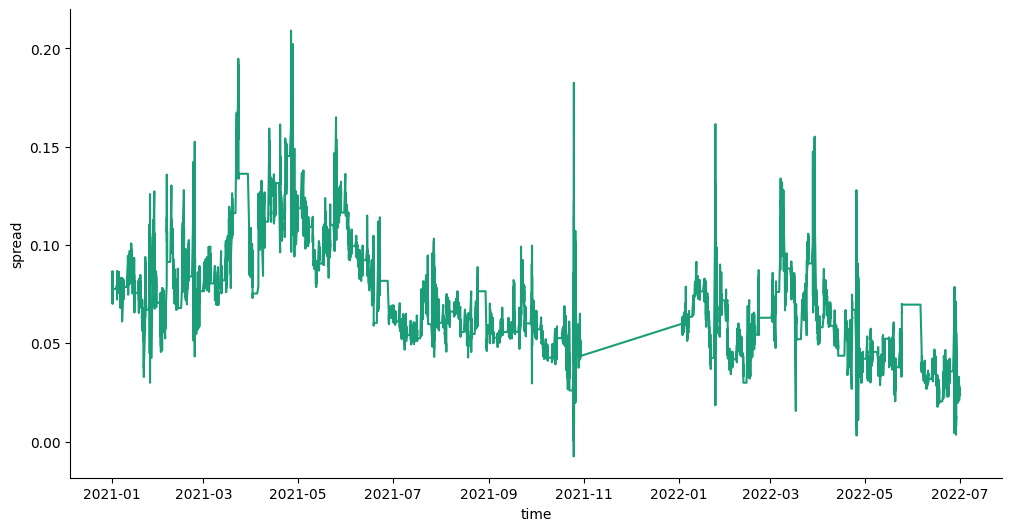

In [44]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['spread']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('spread')

## Z-Score Based Trading Strategy

In [45]:
window = 10
data['spread_mean'] = data['spread'].rolling(window=window).mean()
data['spread_std'] = data['spread'].rolling(window=window).std()
data['spread_zscore'] = (data['spread'] - data['spread_mean']) / data['spread_std']

zscore_entry_threshold = 1.8
zscore_exit_threshold = 0

data['position'] = 0  # 1 for long, -1 for short, 0 for no position
data['p_l'] = np.nan
data['entry_price'] = np.nan

In [46]:
entry_index = None
for i in range(1, len(data)):
    # Exit after 5 days
    if entry_index is not None and (data.loc[i, 'time'] - data.loc[entry_index, 'time']).total_seconds() / 60 > 1875:
        data.loc[i, 'position'] = 0
        data.loc[i, 'p_l'] = data.loc[i, 'spread'] - data.loc[entry_index, 'entry_price']
        entry_index = None
        continue

    # Entry signals
    if data.loc[i - 1, 'spread_zscore'] < -zscore_entry_threshold and data.loc[i, 'position'] == 0:  # Long entry
        data.loc[i, 'position'] = 1
        data.loc[i, 'entry_price'] = data.loc[i, 'spread']
        entry_index = i
    elif data.loc[i - 1, 'spread_zscore'] > zscore_entry_threshold and data.loc[i, 'position'] == 0:  # Short entry
        data.loc[i, 'position'] = -1
        data.loc[i, 'entry_price'] = data.loc[i, 'spread']
        entry_index = i

    # Exit signals
    if entry_index is not None and abs(data.loc[i, 'spread_zscore']) <= zscore_exit_threshold:
        data.loc[i, 'position'] = 0
        data.loc[i, 'p_l'] = data.loc[i, 'spread'] - data.loc[entry_index, 'entry_price']
        entry_index = None

In [47]:
data['p_l'].fillna(0, inplace=True)

total_p_l = data['p_l'].sum()
print(f"Total P/L: {total_p_l}")
daily_returns = data['p_l'].groupby(data['time'].dt.date).sum()
sharpe_ratio = daily_returns.mean() / daily_returns.std()
cumulative_returns = daily_returns.cumsum()
peak = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = np.abs(drawdown.min())

long_trades = data[data['position'] == 1]['position'].count()
short_trades = data[data['position'] == -1]['position'].count()

Total P/L: 0.18460734999999937


In [48]:
print(f"Total P/L: {total_p_l}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")
print(f"Number of Long Trades: {long_trades}")
print(f"Number of Short Trades: {short_trades}")

Total P/L: 0.18460734999999937
Sharpe Ratio: 0.10
Maximum Drawdown: 0.84
Number of Long Trades: 5441
Number of Short Trades: 5342


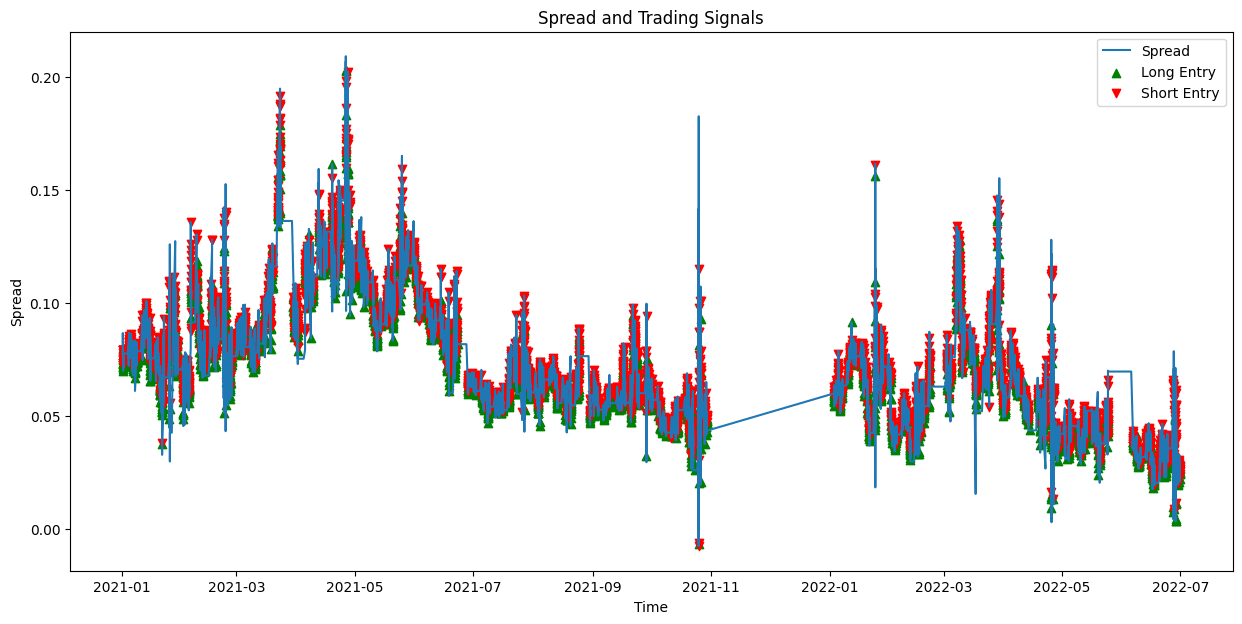

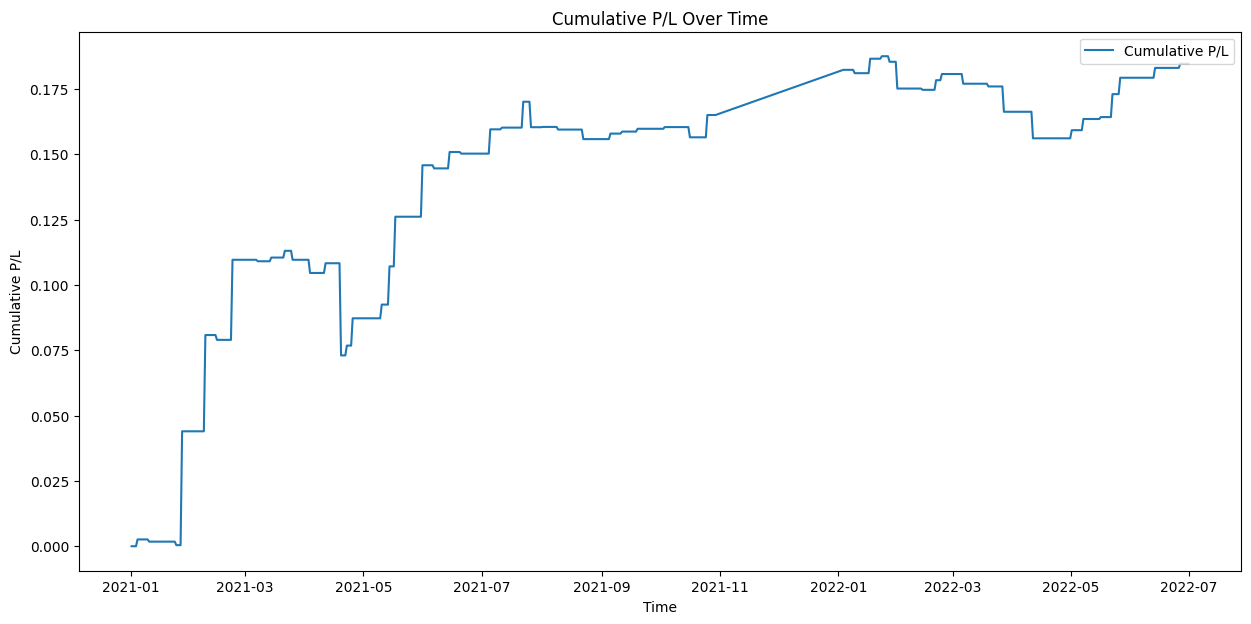

In [49]:
plt.figure(figsize=(15, 7))
plt.plot(data['time'], data['spread'], label='Spread')
plt.scatter(data.loc[data['position'] == 1, 'time'], data.loc[data['position'] == 1, 'spread'], color='g', label='Long Entry', marker='^', alpha=1)
plt.scatter(data.loc[data['position'] == -1, 'time'], data.loc[data['position'] == -1, 'spread'], color='r', label='Short Entry', marker='v', alpha=1)
plt.title("Spread and Trading Signals")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.show()

data['cumulative_p_l'] = data['p_l'].cumsum()
plt.figure(figsize=(15, 7))
plt.plot(data['time'], data['cumulative_p_l'], label='Cumulative P/L')
plt.title("Cumulative P/L Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative P/L")
plt.legend()
plt.show()

### Let's optimize the parameters of the strategy and find the best fit for our dataset.

In [24]:
data_sampled = data.iloc[::10, :].reset_index(drop=True)

window_sizes = [10, 20, 30]
zscore_thresholds = np.arange(1.5, 2.1, 0.3)

best_sharpe_ratio = 0
best_max_drawdown = np.inf
best_window = None
best_zscore_threshold = None
best_summary = {}

# Optimization loop
for window in window_sizes:
    for zscore_threshold in zscore_thresholds:
        data_sampled['spread_mean'] = data_sampled['spread'].rolling(window=window).mean()
        data_sampled['spread_std'] = data_sampled['spread'].rolling(window=window).std()
        data_sampled['spread_zscore'] = (data_sampled['spread'] - data_sampled['spread_mean']) / data_sampled['spread_std']

        data_sampled['position'] = 0
        data_sampled['entry_price'] = np.nan
        data_sampled['p_l'] = 0.0

        entry_index = None
        for i in range(1, len(data_sampled)):
            # Entry logic
            if data_sampled.loc[i - 1, 'spread_zscore'] < -zscore_threshold and data_sampled.loc[i, 'position'] == 0:
                data_sampled.loc[i, 'position'] = 1
                data_sampled.loc[i, 'entry_price'] = data_sampled.loc[i, 'spread']
                entry_index = i
            elif data_sampled.loc[i - 1, 'spread_zscore'] > zscore_threshold and data_sampled.loc[i, 'position'] == 0:
                data_sampled.loc[i, 'position'] = -1
                data_sampled.loc[i, 'entry_price'] = data_sampled.loc[i, 'spread']
                entry_index = i

            # Exit logic
            if entry_index is not None and (data_sampled.loc[i, 'time'] - data_sampled.loc[entry_index, 'time']).total_seconds() / 60 > 1875:
                data_sampled.loc[i, 'p_l'] = data_sampled.loc[i, 'spread'] - data_sampled.loc[entry_index, 'entry_price']
                data_sampled.loc[i, 'position'] = 0
                entry_index = None

        total_pl = data_sampled['p_l'].sum()
        daily_pl = data_sampled.groupby(data_sampled['time'].dt.date)['p_l'].sum()
        sharpe_ratio = daily_pl.mean() / daily_pl.std()
        cumulative_returns = daily_pl.cumsum()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = np.abs(drawdown.min())

        if sharpe_ratio > best_sharpe_ratio or (sharpe_ratio == best_sharpe_ratio and max_drawdown > best_max_drawdown):
            best_sharpe_ratio = sharpe_ratio
            best_max_drawdown = max_drawdown
            best_window = window
            best_zscore_threshold = zscore_threshold
            best_summary = {
                'total_pl': total_pl,
                'total_trades': data_sampled[data_sampled['position'] != 0]['position'].count(),
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown
            }

print("Best Parameters:")
print(f"Best Window Size: {best_window}")
print(f"Best Z-Score Threshold: {best_zscore_threshold:.2f}")
print("Best Performance Summary:")
print(f"Total P/L: {best_summary['total_pl']}")
print(f"Total Trades: {best_summary['total_trades']}")
print(f"Sharpe Ratio: {best_summary['sharpe_ratio']:.2f}")
print(f"Maximum Drawdown: {best_summary['max_drawdown']:.2f}")

Best Parameters:
Best Window Size: 30
Best Z-Score Threshold: 1.50
Best Performance Summary:
Total P/L: 0.23716035000000063
Total Trades: 1478
Sharpe Ratio: 0.20
Maximum Drawdown: inf


### Now, we start experimenting with multiple strategies to find different Sharpe Ratio, Maximum Drawdown and Total P/L

## Bollinger Bands based trading strategy
### Bollinger Bands are envelopes plotted at a standard deviation level above and below a simple moving average of the price. Because the distance of the bands is based on standard deviation, they adjust to volatility swings in the underlying price. Bollinger Bands use 2 parameters, Period and Standard Deviations, StdDev.

In [50]:
bollinger_window = 20
num_std_dev = 2

data['bn_ma'] = data['banknifty'].rolling(window=bollinger_window).mean()
data['bn_std'] = data['banknifty'].rolling(window=bollinger_window).std()
data['bn_upper_band'] = data['bn_ma'] + (data['bn_std'] * num_std_dev)
data['bn_lower_band'] = data['bn_ma'] - (data['bn_std'] * num_std_dev)

data['n_ma'] = data['nifty'].rolling(window=bollinger_window).mean()
data['n_std'] = data['nifty'].rolling(window=bollinger_window).std()
data['n_upper_band'] = data['n_ma'] + (data['n_std'] * num_std_dev)
data['n_lower_band'] = data['n_ma'] - (data['n_std'] * num_std_dev)

data['bollinger_spread'] = data['bn_lower_band'] - data['n_upper_band']
data['spread_mean'] = data['bollinger_spread'].rolling(window=bollinger_window).mean()
data['spread_std'] = data['bollinger_spread'].rolling(window=bollinger_window).std()
data['z_score'] = (data['bollinger_spread'] - data['spread_mean']) / data['spread_std']

entry_threshold = 2
exit_threshold = 0

data['position'] = 0  # 1 for long, -1 for short, 0 for no position
data['p_l'] = np.nan
data['entry_price'] = np.nan

In [51]:
# Trade simulation
entry_index = None
for i in range(1, len(data)):
    current_time = data.loc[i, 'time']
    if entry_index is not None:
        holding_period = (current_time - data.loc[entry_index, 'time']).total_seconds() / 60
        # Exit after 5 days or if the holding period is too long
        if holding_period > 7200:  # 5 days in minutes
            data.loc[i, 'position'] = 0
            if data.loc[entry_index, 'position'] == 1:
                data.loc[i, 'p_l'] = data.loc[i, 'banknifty'] - data.loc[entry_index, 'entry_price']
            else:
                data.loc[i, 'p_l'] = data.loc[entry_index, 'entry_price'] - data.loc[i, 'banknifty']
            entry_index = None
            continue

    # Entry signals based on z-score and Bollinger Bands
    if data.loc[i, 'z_score'] < -entry_threshold and data.loc[i, 'position'] == 0:
        # Long Entry
        data.loc[i, 'position'] = 1
        data.loc[i, 'entry_price'] = data.loc[i, 'banknifty']
        entry_index = i
    elif data.loc[i, 'z_score'] > entry_threshold and data.loc[i, 'position'] == 0:
        # Short Entry
        data.loc[i, 'position'] = -1
        data.loc[i, 'entry_price'] = data.loc[i, 'banknifty']
        entry_index = i

    # Exit signals based on z-score
    if entry_index is not None and abs(data.loc[i, 'z_score']) <= exit_threshold:
        data.loc[i, 'position'] = 0
        if data.loc[entry_index, 'position'] == 1:
            data.loc[i, 'p_l'] = data.loc[i, 'banknifty'] - data.loc[entry_index, 'entry_price']
        else:
            data.loc[i, 'p_l'] = data.loc[entry_index, 'entry_price'] - data.loc[i, 'banknifty']
        entry_index = None

In [52]:
data['p_l'].fillna(0, inplace=True)
data['cumulative_p_l'] = data['p_l'].cumsum()

total_p_l = data['cumulative_p_l'].iloc[-1]
daily_returns = data['p_l'].groupby(data['time'].dt.date).sum()
sharpe_ratio = daily_returns.mean() / daily_returns.std()
cumulative_returns = daily_returns.cumsum()
peak = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = np.abs(drawdown.min())

long_trades = data[data['position'] == 1]['position'].count()
short_trades = data[data['position'] == -1]['position'].count()

print(f"Total P/L: {total_p_l}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")
print(f"Number of Long Trades: {long_trades}")
print(f"Number of Short Trades: {short_trades}")

Total P/L: 0.006874000000000019
Sharpe Ratio: 0.02
Maximum Drawdown: inf
Number of Long Trades: 9889
Number of Short Trades: 8081


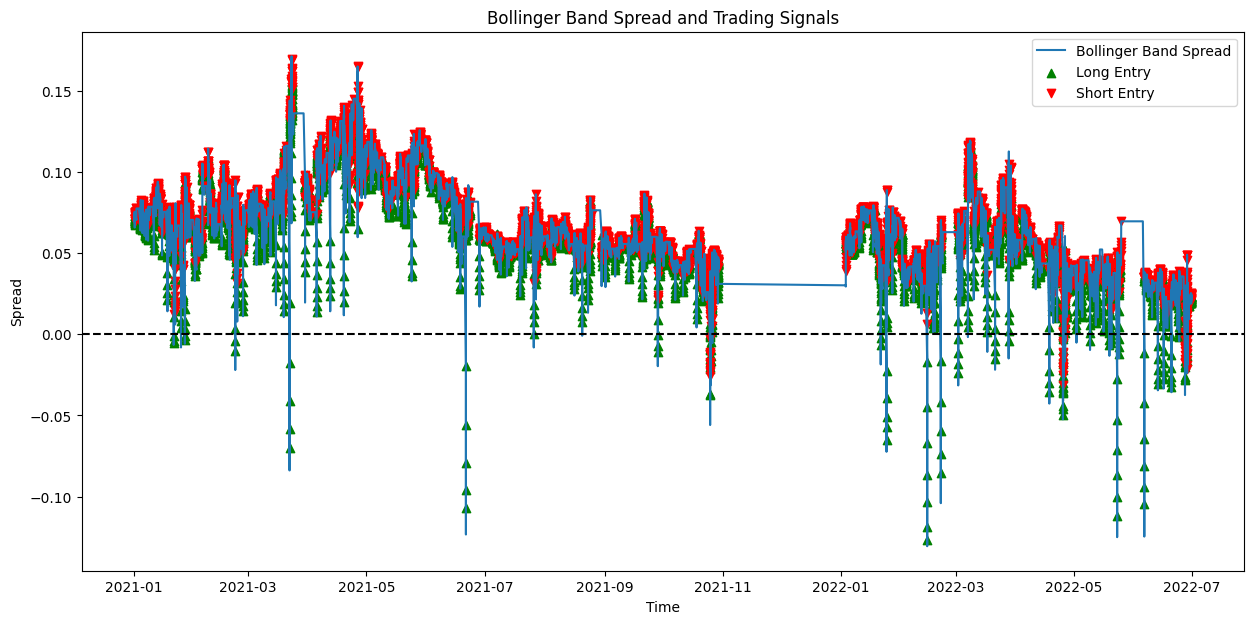

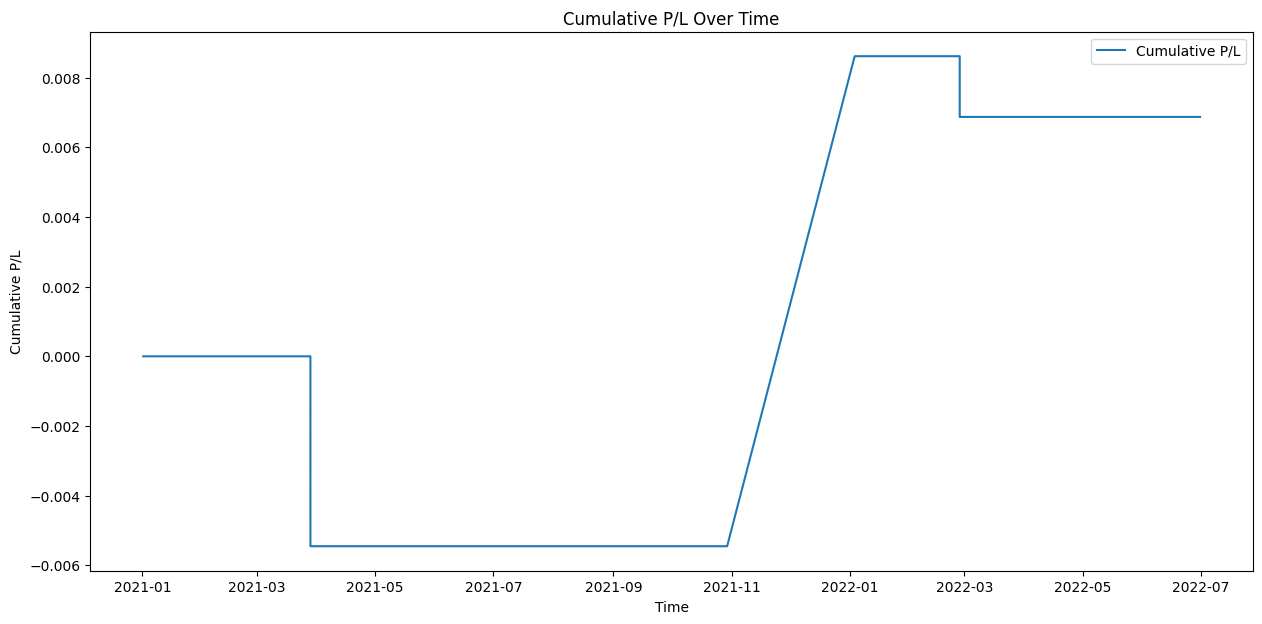

In [53]:
plt.figure(figsize=(15, 7))
plt.plot(data['time'], data['bollinger_spread'], label='Bollinger Band Spread')
plt.scatter(data.loc[data['position'] == 1, 'time'], data.loc[data['position'] == 1, 'bollinger_spread'], color='g', label='Long Entry', marker='^', alpha=1)
plt.scatter(data.loc[data['position'] == -1, 'time'], data.loc[data['position'] == -1, 'bollinger_spread'], color='r', label='Short Entry', marker='v', alpha=1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Bollinger Band Spread and Trading Signals")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(data['time'], data['cumulative_p_l'], label='Cumulative P/L')
plt.title("Cumulative P/L Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative P/L")
plt.legend()
plt.show()

### Let's optimize the parameters of the strategy and find the best fit for our dataset.

In [ ]:
def trading_strategy(params):
    bollinger_window, entry_threshold, exit_threshold = params

    data['bn_ma'] = data['banknifty'].rolling(window=int(bollinger_window)).mean()
    data['bn_std'] = data['banknifty'].rolling(window=int(bollinger_window)).std()
    data['bn_upper_band'] = data['bn_ma'] + (data['bn_std'] * 2)
    data['bn_lower_band'] = data['bn_ma'] - (data['bn_std'] * 2)
    data['n_ma'] = data['nifty'].rolling(window=int(bollinger_window)).mean()
    data['n_std'] = data['nifty'].rolling(window=int(bollinger_window)).std()
    data['n_upper_band'] = data['n_ma'] + (data['n_std'] * 2)
    data['n_lower_band'] = data['n_ma'] - (data['n_std'] * 2)

    data['bollinger_spread'] = data['bn_lower_band'] - data['n_upper_band']
    data['spread_mean'] = data['bollinger_spread'].rolling(window=int(bollinger_window)).mean()
    data['spread_std'] = data['bollinger_spread'].rolling(window=int(bollinger_window)).std()
    data['z_score'] = (data['bollinger_spread'] - data['spread_mean']) / data['spread_std']

    data['position'] = 0
    entry_index = None
    for i in range(1, len(data)):
        # Entry conditions
        if data.loc[i, 'z_score'] < -entry_threshold and data.loc[i, 'position'] == 0:
            data.loc[i, 'position'] = 1
            entry_index = i
        elif data.loc[i, 'z_score'] > entry_threshold and data.loc[i, 'position'] == 0:
            data.loc[i, 'position'] = -1
            entry_index = i

        # Exit conditions
        if entry_index is not None and abs(data.loc[i, 'z_score']) <= exit_threshold:
            data.loc[i, 'position'] = 0
            entry_index = None

    data['p_l'] = np.where(data['position'] == 1, data['banknifty'].diff(),
                           np.where(data['position'] == -1, -data['banknifty'].diff(), 0))
    data['p_l'].fillna(0, inplace=True)
    data['cumulative_p_l'] = data['p_l'].cumsum()

    daily_returns = data['p_l'].groupby(data['time'].dt.date).sum()
    sharpe_ratio = daily_returns.mean() / daily_returns.std()
    cumulative_returns = daily_returns.cumsum()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = np.abs((cumulative_returns - peak).min())

    return -sharpe_ratio+drawdown

param_ranges = ((5, 30), (1.0, 3.0), (-1.0, 1.0))

result = brute(trading_strategy, ranges=param_ranges, finish=None)

bollinger_window_opt, entry_threshold_opt, exit_threshold_opt = result

print(f"Optimized Bollinger Window: {bollinger_window_opt}, "
      f"Entry Threshold: {entry_threshold_opt}, "
      f"Exit Threshold: {exit_threshold_opt}")

## Simple Moving Average with Z-Score Strategy

In [54]:
sma_window = 20

data['bn_sma'] = data['banknifty'].rolling(window=sma_window).mean()
data['n_sma'] = data['nifty'].rolling(window=sma_window).mean()

data['sma_spread'] = data['bn_sma'] - data['n_sma']
data['spread_mean'] = data['sma_spread'].rolling(window=sma_window).mean()
data['spread_std'] = data['sma_spread'].rolling(window=sma_window).std()
data['z_score'] = (data['sma_spread'] - data['spread_mean']) / data['spread_std']

z_entry_threshold = 2
z_exit_threshold = 0

data['position'] = 0  # 1 for long, -1 for short, 0 for no position
data['p_l'] = np.nan
data['entry_price'] = np.nan

In [55]:
# Trade simulation
entry_index = None
for i in range(1, len(data)):
    current_time = data.loc[i, 'time']

    # Check for exit after 5 days
    if entry_index is not None:
        holding_period = (current_time - data.loc[entry_index, 'time']).total_seconds() / 60
        if holding_period > 7200:  # 5 days in minutes
            data.loc[i, 'position'] = 0
            data.loc[i, 'p_l'] = data.loc[i, 'banknifty'] - data.loc[entry_index, 'entry_price'] if data.loc[entry_index, 'position'] == 1 else data.loc[entry_index, 'entry_price'] - data.loc[i, 'banknifty']
            entry_index = None

    # Entry signals based on z-score and SMA
    if data.loc[i, 'z_score'] < -z_entry_threshold and data.loc[i, 'position'] == 0:
        data.loc[i, 'position'] = 1
        data.loc[i, 'entry_price'] = data.loc[i, 'banknifty']
        entry_index = i
    elif data.loc[i, 'z_score'] > z_entry_threshold and data.loc[i, 'position'] == 0:
        data.loc[i, 'position'] = -1
        data.loc[i, 'entry_price'] = data.loc[i, 'banknifty']
        entry_index = i

    # Exit signals based on z-score
    if entry_index is not None and abs(data.loc[i, 'z_score']) <= z_exit_threshold:
        data.loc[i, 'position'] = 0
        data.loc[i, 'p_l'] = data.loc[i, 'banknifty'] - data.loc[entry_index, 'entry_price'] if data.loc[entry_index, 'position'] == 1 else data.loc[entry_index, 'entry_price'] - data.loc[i, 'banknifty']
        entry_index = None

In [56]:
data['p_l'].fillna(0, inplace=True)
data['cumulative_p_l'] = data['p_l'].cumsum()

total_p_l = data['cumulative_p_l'].iloc[-1]
daily_returns = data['p_l'].groupby(data['time'].dt.date).sum()
sharpe_ratio = daily_returns.mean() / daily_returns.std()
cumulative_returns = daily_returns.cumsum()
peak = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = np.abs(drawdown.min())

long_trades = data[data['position'] == 1]['position'].count()
short_trades = data[data['position'] == -1]['position'].count()

print(f"Total P/L: {total_p_l}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")
print(f"Number of Long Trades: {long_trades}")
print(f"Number of Short Trades: {short_trades}")

Total P/L: -0.010786000000000018
Sharpe Ratio: -0.02
Maximum Drawdown: inf
Number of Long Trades: 9800
Number of Short Trades: 9310


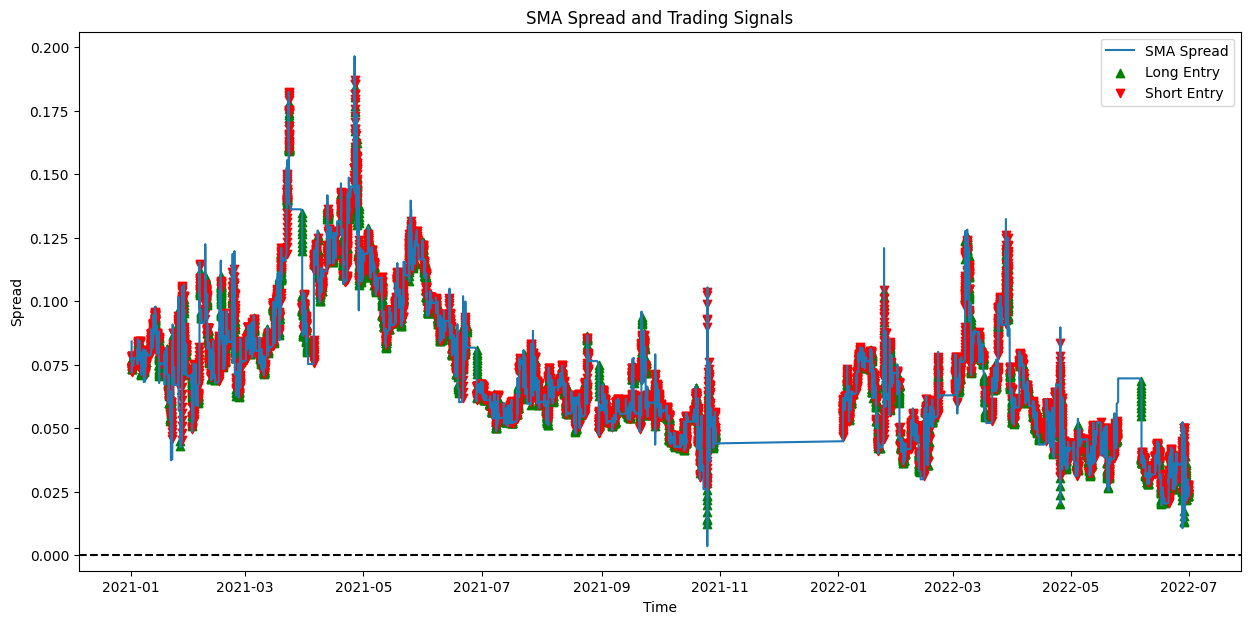

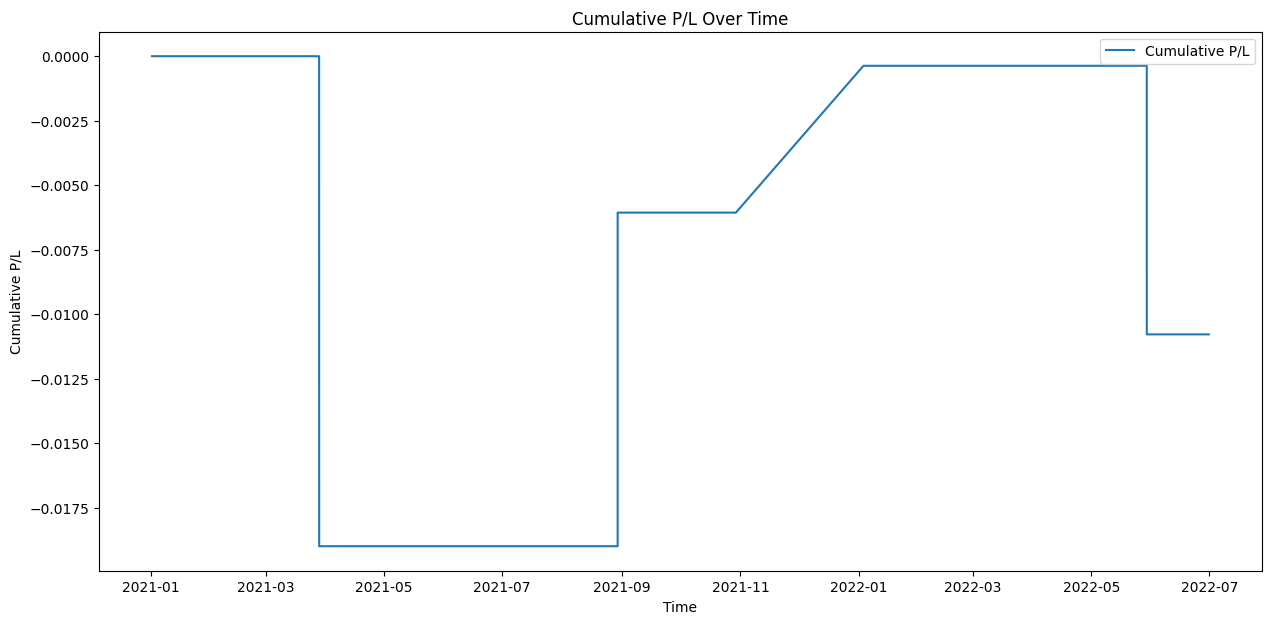

In [57]:
plt.figure(figsize=(15, 7))
plt.plot(data['time'], data['sma_spread'], label='SMA Spread')
plt.scatter(data.loc[data['position'] == 1, 'time'], data.loc[data['position'] == 1, 'sma_spread'], color='g', label='Long Entry', marker='^', alpha=1)
plt.scatter(data.loc[data['position'] == -1, 'time'], data.loc[data['position'] == -1, 'sma_spread'], color='r', label='Short Entry', marker='v', alpha=1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("SMA Spread and Trading Signals")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(data['time'], data['cumulative_p_l'], label='Cumulative P/L')
plt.title("Cumulative P/L Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative P/L")
plt.legend()
plt.show()

### Let's optimize the parameters of the strategy and find the best fit for our dataset.

In [ ]:
def trading_strategy(params):
    sma_window, z_entry_threshold, z_exit_threshold = params

    data['bn_sma'] = data['banknifty'].rolling(window=int(sma_window)).mean()
    data['n_sma'] = data['nifty'].rolling(window=int(sma_window)).mean()

    data['sma_spread'] = data['bn_sma'] - data['n_sma']
    data['spread_mean'] = data['sma_spread'].rolling(window=int(sma_window)).mean()
    data['spread_std'] = data['sma_spread'].rolling(window=int(sma_window)).std()
    data['z_score'] = (data['sma_spread'] - data['spread_mean']) / data['spread_std']

    data['position'] = 0  # 1 for long, -1 for short, 0 for no position
    entry_index = None

    for i in range(1, len(data)):
        # Entry signals
        if data.loc[i, 'z_score'] < -z_entry_threshold and data.loc[i, 'position'] == 0:
            data.loc[i, 'position'] = 1
            entry_index = i
        elif data.loc[i, 'z_score'] > z_entry_threshold and data.loc[i, 'position'] == 0:
            data.loc[i, 'position'] = -1
            entry_index = i

        # Exit signals
        if entry_index is not None and abs(data.loc[i, 'z_score']) <= z_exit_threshold:
            data.loc[i, 'position'] = 0
            entry_index = None

    data['p_l'] = np.where(data['position'] == 1, data['banknifty'].diff(),
                           np.where(data['position'] == -1, -data['banknifty'].diff(), 0))
    data['p_l'].fillna(0, inplace=True)
    data['cumulative_p_l'] = data['p_l'].cumsum()

    daily_returns = data['p_l'].groupby(data['time'].dt.date).sum()
    sharpe_ratio = daily_returns.mean() / daily_returns.std()

    return -sharpe_ratio

param_ranges = (slice(5, 30, 5),
                slice(1.0, 3.0, 0.5),
                slice(0, 1.0, 0.25))

optimal_params = brute(trading_strategy, ranges=param_ranges, finish=None)

print(f"Optimized SMA Window: {optimal_params[0]}")
print(f"Optimized Z-score Entry Threshold: {optimal_params[1]}")
print(f"Optimized Z-score Exit Threshold: {optimal_params[2]}")

## Linear Regression Method

In [58]:
x = data['banknifty']
y = data['nifty']

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

hedge_ratio = model.params[1]

data['spread'] = y - hedge_ratio * x['banknifty']

spread_mean = data['spread'].rolling(window=20).mean()
spread_std = data['spread'].rolling(window=20).std()
data['z_score'] = (data['spread'] - spread_mean) / spread_std

entry_threshold = 2.0
exit_threshold = 0.5

data['position'] = 0
data.loc[data['z_score'] > entry_threshold, 'position'] = -1
data.loc[data['z_score'] < -entry_threshold, 'position'] = 1
data.loc[abs(data['z_score']) < exit_threshold, 'position'] = 0

data['returns'] = data['position'].shift(1) * data['spread'].pct_change()
data['cumulative_returns'] = data['returns'].cumsum()

sharpe_ratio = data['returns'].mean() / data['returns'].std()
cumulative_returns = data['cumulative_returns'].iloc[-1]
drawdown = (data['cumulative_returns'].cummax() - data['cumulative_returns']).max()

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Cumulative Returns: {cumulative_returns:.2f}")
print(f"Maximum Drawdown: {drawdown:.2f}")

Sharpe Ratio: 0.00
Cumulative Returns: 140.92
Maximum Drawdown: 534.16


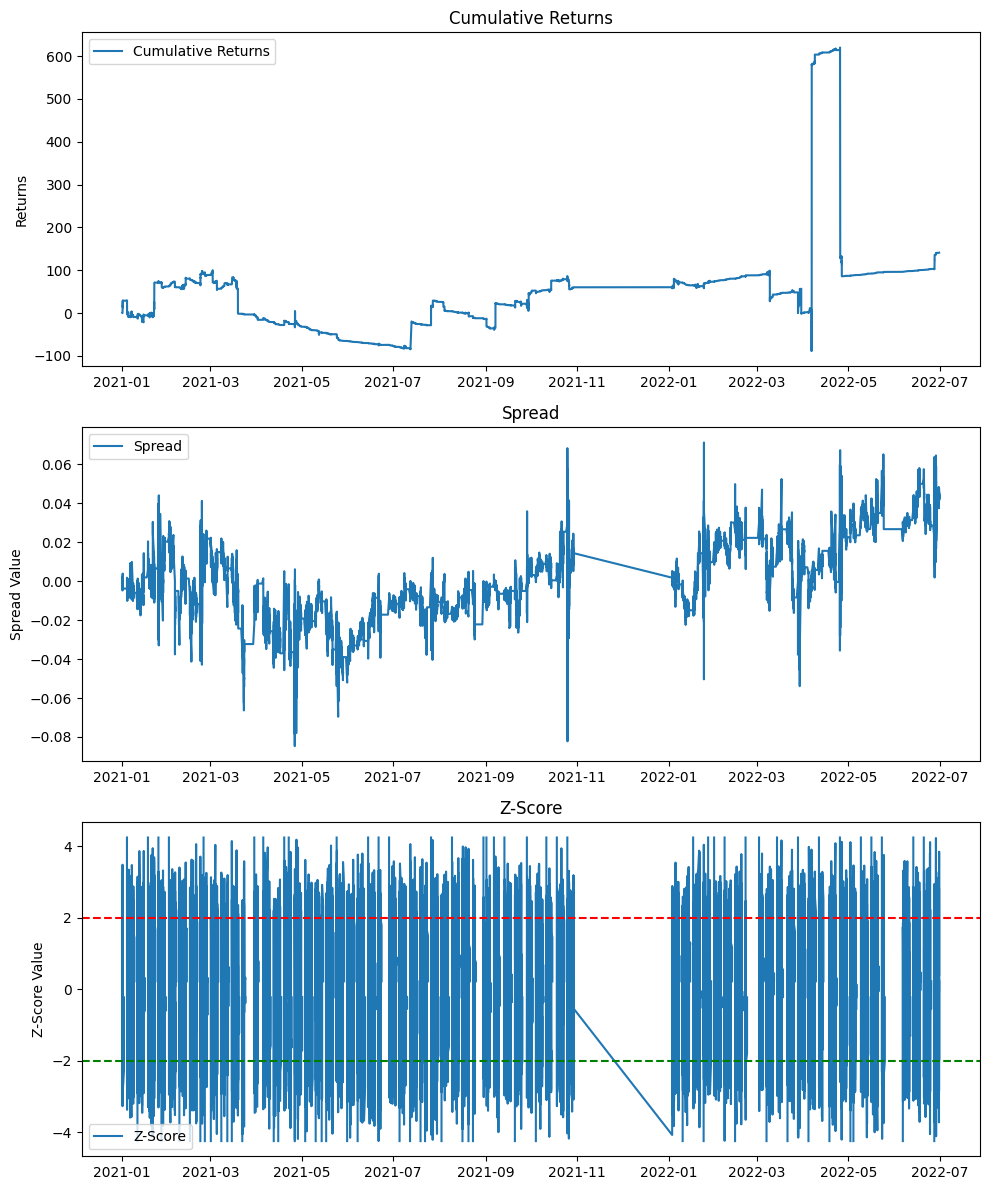

In [59]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
ax[0].plot(data['time'], data['cumulative_returns'], label='Cumulative Returns')
ax[0].set_title('Cumulative Returns')
ax[0].set_ylabel('Returns')
ax[0].legend()

ax[1].plot(data['time'], data['spread'], label='Spread')
ax[1].set_title('Spread')
ax[1].set_ylabel('Spread Value')
ax[1].legend()

ax[2].plot(data['time'], data['z_score'], label='Z-Score')
ax[2].set_title('Z-Score')
ax[2].set_ylabel('Z-Score Value')
ax[2].axhline(y=entry_threshold, color='r', linestyle='--')
ax[2].axhline(y=-entry_threshold, color='g', linestyle='--')
ax[2].legend()

plt.tight_layout()
plt.show()

### Let's optimize the parameters of the strategy and find the best fit for our dataset.

In [ ]:
x = data['banknifty']
y = data['nifty']

def objective_function(params):
    entry_threshold, exit_threshold = params

    x_with_const = sm.add_constant(x)
    model = sm.OLS(y, x_with_const).fit()
    hedge_ratio = model.params[1]
    data['spread'] = y - hedge_ratio * x
    spread_mean = data['spread'].rolling(window=20).mean()
    spread_std = data['spread'].rolling(window=20).std()
    data['z_score'] = (data['spread'] - spread_mean) / spread_std

    data['position'] = 0
    data['returns'] = 0

    entry_time = None

    for i in range(len(data)):
        if entry_time is not None and (data.loc[i, 'time'] - entry_time).days >= 5:
            # Exit position after 5 days
            data.loc[i, 'position'] = 0
            entry_time = None

        elif data.loc[i, 'z_score'] > entry_threshold:
            data.loc[i, 'position'] = -1  # Short
            entry_time = data.loc[i, 'time']

        elif data.loc[i, 'z_score'] < -entry_threshold:
            data.loc[i, 'position'] = 1   # Long
            entry_time = data.loc[i, 'time']

        elif abs(data.loc[i, 'z_score']) <= exit_threshold:
            # Exit based on z-score threshold
            data.loc[i, 'position'] = 0
            entry_time = None

        if i > 0:  # Calculate returns
            data.loc[i, 'returns'] = data.loc[i - 1, 'position'] * (data.loc[i, 'spread'] - data.loc[i - 1, 'spread'])

    data['cumulative_returns'] = data['returns'].cumsum()
    sharpe_ratio = data['returns'].mean() / data['returns'].std() * np.sqrt(252)
    drawdown = (data['cumulative_returns'].cummax() - data['cumulative_returns']).max()

    return -sharpe_ratio + drawdown

initial_guess = [2.0, 0.5]
bounds = [(0.5, 3.0), (0.1, 1.5)]

result = minimize(objective_function, initial_guess, bounds=bounds, method='L-BFGS-B')

if result.success:
    optimized_entry_threshold, optimized_exit_threshold = result.x
    print(f"Optimized Entry Threshold: {optimized_entry_threshold:.2f}")
    print(f"Optimized Exit Threshold: {optimized_exit_threshold:.2f}")
else:
    print("Optimization was not successful. Reason:", result.message)

## Classifier Based Trading Strategy

In [60]:
optimal_window = 20
data['spread_ma20'] = data['spread'].rolling(window=optimal_window).mean()
data['spread_std20'] = data['spread'].rolling(window=optimal_window).std()
data['upper_band'] = data['spread_ma20'] + (data['spread_std20'] * 2)
data['lower_band'] = data['spread_ma20'] - (data['spread_std20'] * 2)
data['target'] = (data['spread'].diff() > 0).astype(int).shift(-1)
data.dropna(inplace=True)

X_optimal = data[['spread', 'spread_ma20', 'upper_band', 'lower_band']]
y_optimal = data['target']

X_train_optimal, X_test_optimal, y_train_optimal, y_test_optimal = train_test_split(X_optimal, y_optimal, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_optimal_scaled = scaler.fit_transform(X_train_optimal)
X_test_optimal_scaled = scaler.transform(X_test_optimal)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_optimal_scaled, y_train_optimal)

y_pred_optimal = clf.predict(X_test_optimal_scaled)
accuracy_optimal = accuracy_score(y_test_optimal, y_pred_optimal)

X_scaled_optimal = scaler.transform(X_optimal)
data['prediction'] = clf.predict(X_scaled_optimal)
data['position'] = data['prediction'].shift(1)
data['daily_return'] = data['spread'].diff() * data['position']
data['cumulative_pl'] = data['daily_return'].cumsum()

total_pl_optimal = data['cumulative_pl'].iloc[-1]
sharpe_ratio_optimal = data['daily_return'].mean() / data['daily_return'].std() * np.sqrt(252)
peak_optimal = data['cumulative_pl'].expanding(min_periods=1).max()
drawdown_optimal = (data['cumulative_pl'] - peak_optimal) / peak_optimal
max_drawdown_optimal = np.abs(drawdown_optimal.min())

print(f"Accuracy: {accuracy_optimal}")
print(f"Total P/L: {total_pl_optimal}")
print(f"Sharpe Ratio: {sharpe_ratio_optimal}")
print(f"Maximum Drawdown: {max_drawdown_optimal}")

Accuracy: 0.5537168374047806
Total P/L: 8.663395112005288
Sharpe Ratio: 2.3224496482963315
Maximum Drawdown: inf


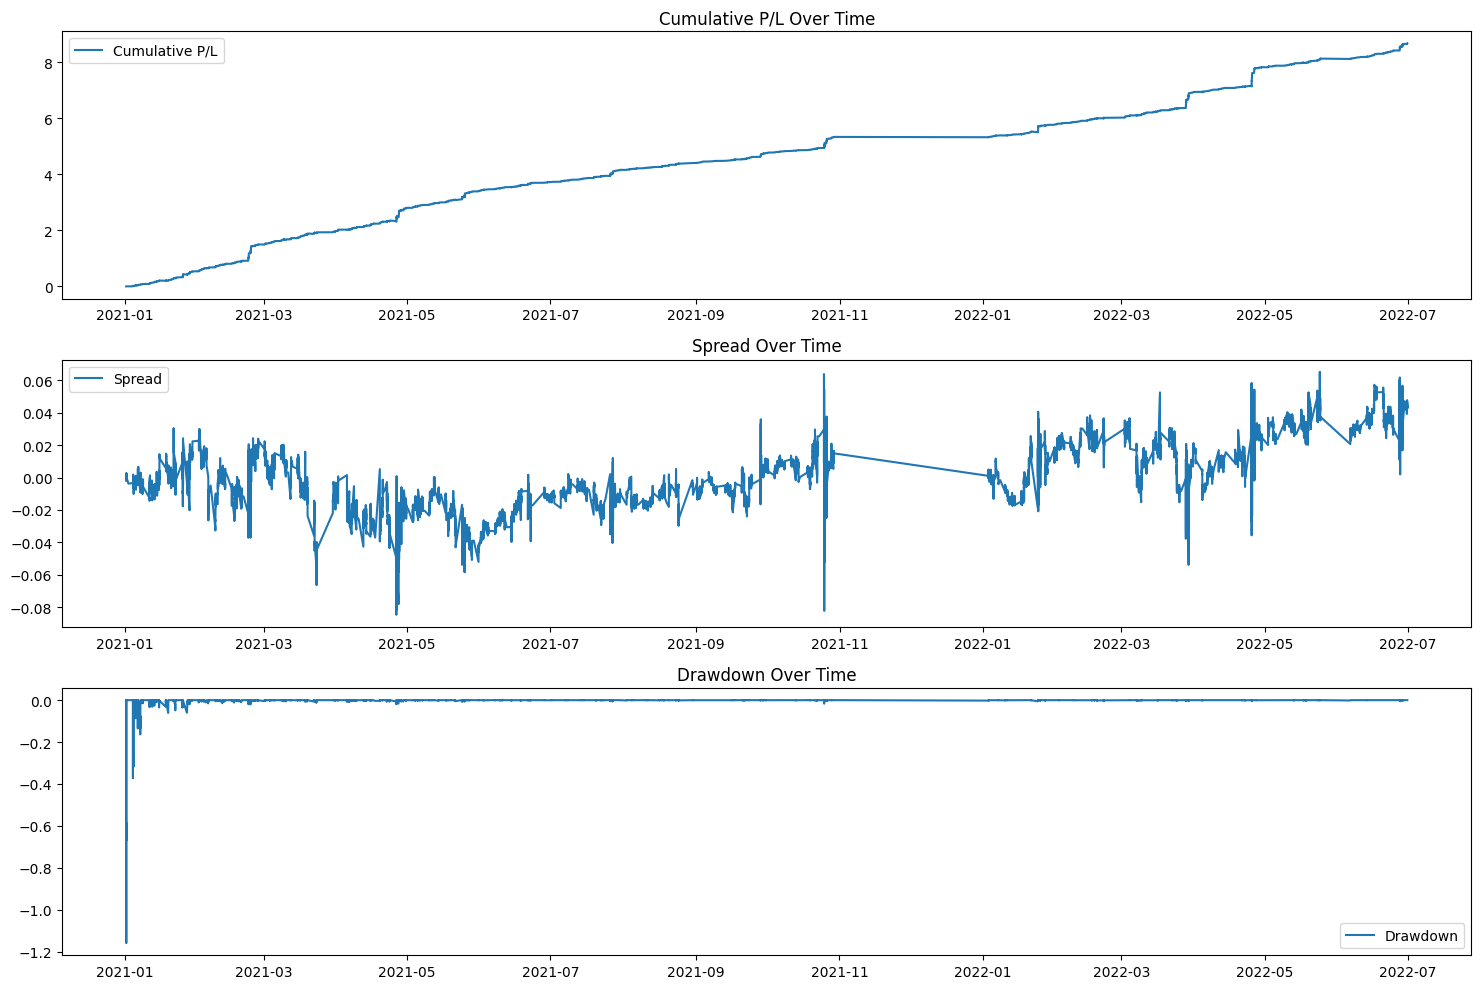

In [61]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(data['time'], data['cumulative_pl'], label='Cumulative P/L')
plt.title('Cumulative P/L Over Time')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data['time'], data['spread'], label='Spread')
plt.title('Spread Over Time')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data['time'], drawdown_optimal, label='Drawdown')
plt.title('Drawdown Over Time')
plt.legend()

plt.tight_layout()
plt.show()

### Let's optimize the parameters of the strategy and find the best fit for our dataset.

In [ ]:
window_size = 20
data['spread_ma'] = data['spread'].rolling(window=window_size).mean()
data['spread_std'] = data['spread'].rolling(window=window_size).std()
data['upper_band'] = data['spread_ma'] + (data['spread_std'] * 2)
data['lower_band'] = data['spread_ma'] - (data['spread_std'] * 2)
data['target'] = (data['spread'].diff() > 0).astype(int).shift(-1)
data.dropna(inplace=True)

X = data[['spread', 'spread_ma', 'upper_band', 'lower_band']]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def custom_scorer(y_true, y_pred):
    positions = np.where(y_pred > 0.5, 1, -1)
    daily_returns = positions * zscore(y_true.diff().fillna(0))
    sharpe_ratio = daily_returns.mean() / daily_returns.std()

    cumulative_returns = np.cumsum(daily_returns)
    drawdown = (cumulative_returns - np.maximum.accumulate(cumulative_returns)).min()

    score = sharpe_ratio + drawdown

    return score

model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
}
scorer = make_scorer(custom_scorer, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
test_score = custom_scorer(y_test, y_pred)
print("Test score with best parameters:", test_score)

### After analysing different strategies(Z-score based, Bollinger Bands, Simple Moving Average, Linear Regression, Classifier Model), we can see that the strategy primarily depends on the parameters of the model and tuning them can produce much better results. I was not able to run all the optimizers code due to limitations of my computer but those algorithms will be able to help increase the results of the strategies. I have also gone through some unique strategies involving Kalman Filters and Technical Indicators like RSI and MACD, but I was not able to execute them due to their complexities.

### All of these strategies were studied and found out after reading through different sources. There might be certain errors in the code as I have tried to create the strategies on my own. But after giving a good amount of time for the assignment, I have a good understanding of Pair Trading and it's strategies.

### Best Regards,
### Harsheet Singh
### 21D170018